<a href="https://colab.research.google.com/github/srivastavask/cvlab-ai/blob/main/lab1/B41_E22CSEU1213_Kanishka/lab7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.datasets import cifar100

# Load dataset
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

# Normalize pixel values between [0,1]
x_train, x_test = x_train / 255.0, x_test / 255.0

# Convert to grayscale if required
def rgb2gray(images):
    return np.dot(images[..., :3], [0.2989, 0.5870, 0.1140])[..., np.newaxis]

gray_train, gray_test = rgb2gray(x_train), rgb2gray(x_test)

# Resize images if necessary (CIFAR-100 is already 32x32)
print(f"Train shape: {gray_train.shape}, Test shape: {gray_test.shape}")


Train shape: (50000, 32, 32, 1), Test shape: (10000, 32, 32, 1)


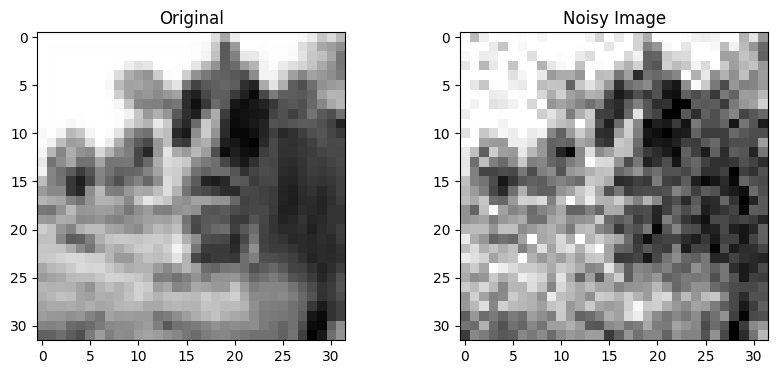

In [ ]:
def add_noise(images, noise_type="gaussian"):
    noisy_images = images.copy()
    if noise_type == "gaussian":
        noise = np.random.normal(0, 0.1, images.shape)
        noisy_images += noise
    elif noise_type == "salt_pepper":
        salt_vs_pepper = 0.5
        amount = 0.02
        num_salt = np.ceil(amount * images.size * salt_vs_pepper)
        coords = [np.random.randint(0, i, int(num_salt)) for i in images.shape]
        noisy_images[tuple(coords)] = 1
    return np.clip(noisy_images, 0, 1)

# Add Gaussian noise to training images
deg_train = add_noise(gray_train, "gaussian")

# Visualize Original vs Noisy Image
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(gray_train[0].squeeze(), cmap="gray")
plt.title("Original")
plt.subplot(1, 2, 2)
plt.imshow(deg_train[0].squeeze(), cmap="gray")
plt.title("Noisy Image")
plt.show()


In [ ]:
def build_autoencoder():
    input_img = keras.Input(shape=(32, 32, 1))

    # Encoder
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = keras.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

# Initialize Autoencoder
autoencoder = build_autoencoder()
autoencoder.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 16, 16, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 8, 8, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 16, 16, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 32, 32, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,353 (110.75 KB)

 Trainable params: 28,353 (110.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
autoencoder.fit(deg_train, gray_train, epochs=10, batch_size=64, shuffle=True, validation_split=0.1)


Epoch 1/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0145 - val_loss: 0.0057
Epoch 2/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0054 - val_loss: 0.0049
Epoch 3/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0047 - val_loss: 0.0047
Epoch 4/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 5/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0042 - val_loss: 0.0042
Epoch 6/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 7/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 8/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 9/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 10/10
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0036 - val_loss: 0.0035


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Average PSNR: 27.76512979850812


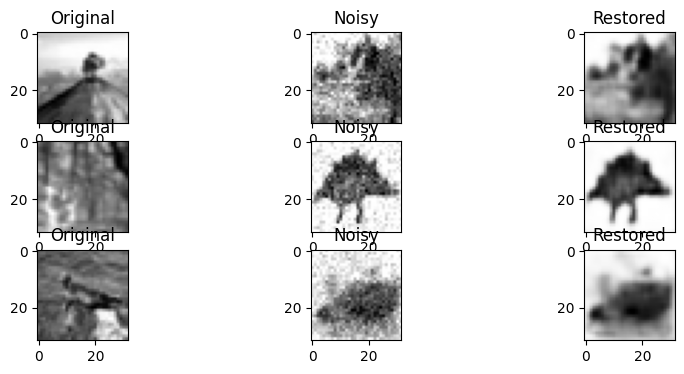

In [ ]:
# Predict restored images
restored_images = autoencoder.predict(deg_train[:10])

# Compute PSNR
import cv2

def psnr(original, restored):
    mse = np.mean((original - restored) ** 2)
    if mse == 0:
        return 100
    max_pixel = 1.0  # Since images are normalized
    return 20 * np.log10(max_pixel / np.sqrt(mse))

psnr_values = [psnr(gray_test[i], autoencoder.predict(gray_test[i:i+1])[0]) for i in range(10)]
print("Average PSNR:", np.mean(psnr_values))

# Visualize Original vs Noisy vs Restored Images
plt.figure(figsize=(10, 4))
for i in range(3):
    plt.subplot(3, 3, i * 3 + 1)
    plt.imshow(gray_test[i].squeeze(), cmap="gray")
    plt.title("Original")

    plt.subplot(3, 3, i * 3 + 2)
    plt.imshow(deg_train[i].squeeze(), cmap="gray")
    plt.title("Noisy")

    plt.subplot(3, 3, i * 3 + 3)
    plt.imshow(restored_images[i].squeeze(), cmap="gray")
    plt.title("Restored")
plt.show()


# **TASK 2**

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam


In [ ]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

# Normalize the dataset
x_train, x_test = x_train / 255.0, x_test / 255.0

# Print dataset shape
print(f"Train shape: {x_train.shape}, Test shape: {x_test.shape}")


Train shape: (50000, 32, 32, 3), Test shape: (10000, 32, 32, 3)


In [ ]:
# Load VGG16 Model
base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
base_model_vgg.trainable = False

x = Flatten()(base_model_vgg.output)
x = Dense(512, activation='relu')(x)
x = Dense(100, activation='softmax')(x)
vgg_model = Model(inputs=base_model_vgg.input, outputs=x)
vgg_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
vgg_model.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_test, y_test))


Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - accuracy: 0.1773 - loss: 3.5617 - val_accuracy: 0.2964 - val_loss: 2.8120
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.3212 - loss: 2.6926 - val_accuracy: 0.3259 - val_loss: 2.6787
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.3550 - loss: 2.5180 - val_accuracy: 0.3426 - val_loss: 2.6070
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.3878 - loss: 2.3640 - val_accuracy: 0.3540 - val_loss: 2.5531
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.4122 - loss: 2.2578 - val_accuracy: 0.3624 - val_loss: 2.5253


In [ ]:
vgg_loss, vgg_acc = vgg_model.evaluate(x_test, y_test)
print(f"VGG16 Accuracy: {vgg_acc * 100:.2f}%")


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3679 - loss: 2.5277
VGG16 Accuracy: 36.24%


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

alexnet = Sequential([
    Conv2D(96, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(100, activation='softmax')
])

alexnet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train AlexNet
alexnet.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_test, y_test))

# Evaluate AlexNet
alex_loss, alex_acc = alexnet.evaluate(x_test, y_test)
print(f"AlexNet Accuracy: {alex_acc * 100:.2f}%")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.0649 - loss: 4.1851 - val_accuracy: 0.2132 - val_loss: 3.3050
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.2086 - loss: 3.2820 - val_accuracy: 0.3025 - val_loss: 2.9035
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.2744 - loss: 2.9189 - val_accuracy: 0.3375 - val_loss: 2.6263
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.3211 - loss: 2.6916 - val_accuracy: 0.3571 - val_loss: 2.5269
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.3560 - loss: 2.5151 - val_accuracy: 0.3804 - val_loss: 2.4597
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3760 - loss: 2.4680
AlexNet Accuracy: 38.04%
